<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.14
Notebook id          : BHPD2
Run time             : Wednesday 10 February 2021, 09:09:41
TensorFlow version   : 2.4.0
Keras version        : 2.4.0
Datasets dir         : /gpfswork/rech/mlh/uja62cb/datasets
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.71,10.82,11.48,0.07,0.56,6.29,69.60,3.70,9.83,412.07,18.49,353.83,12.65
std,8.65,21.95,6.96,0.25,0.12,0.69,27.71,2.03,8.83,171.86,2.19,94.75,7.05
min,0.01,0.00,0.74,0.00,0.39,3.56,2.90,1.17,1.00,188.00,12.60,0.32,1.92
25%,0.08,0.00,5.19,0.00,0.46,5.89,46.83,2.06,4.00,277.50,17.33,372.83,7.18
50%,0.27,0.00,9.90,0.00,0.54,6.21,78.80,3.09,5.00,330.00,19.10,390.94,11.35
75%,4.08,16.62,18.10,0.00,0.63,6.61,94.30,5.12,24.00,666.00,20.20,396.03,17.06
max,88.98,95.00,27.74,1.00,0.87,8.72,100.00,10.71,24.00,711.00,21.20,396.90,34.77


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.43,-0.49,-1.54,-0.27,-1.50,-3.94,-2.41,-1.25,-1.00,-1.30,-2.68,-3.73,-1.52
25%,-0.42,-0.49,-0.90,-0.27,-0.87,-0.57,-0.82,-0.81,-0.66,-0.78,-0.53,0.20,-0.78
50%,-0.40,-0.49,-0.23,-0.27,-0.18,-0.10,0.33,-0.30,-0.55,-0.48,0.28,0.39,-0.19
75%,0.04,0.26,0.95,-0.27,0.60,0.47,0.89,0.70,1.61,1.48,0.78,0.45,0.63
max,9.85,3.84,2.34,3.70,2.68,3.53,1.10,3.46,1.61,1.74,1.24,0.45,3.14


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 34s - loss: 507.9354 - mae: 22.1192 - mse: 507.9354

33/36 [==========================>...] - ETA: 0s - loss: 582.8394 - mae: 22.2024 - mse: 582.8394 

36/36 [==============================] - 2s 24ms/step - loss: 574.0025 - mae: 21.9946 - mse: 574.0025 - val_loss: 376.9288 - val_mae: 17.3666 - val_mse: 376.9288


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 210.9013 - mae: 12.7813 - mse: 210.9013

34/36 [===========================>..] - ETA: 0s - loss: 334.3468 - mae: 15.8430 - mse: 334.3468

36/36 [==============================] - 0s 4ms/step - loss: 329.5558 - mae: 15.6914 - mse: 329.5558 - val_loss: 160.1071 - val_mae: 10.4954 - val_mse: 160.1071


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 158.8152 - mae: 9.9032 - mse: 158.8152

34/36 [===========================>..] - ETA: 0s - loss: 138.2656 - mae: 9.2080 - mse: 138.2656

36/36 [==============================] - 0s 4ms/step - loss: 135.4299 - mae: 9.0885 - mse: 135.4299 - val_loss: 70.2333 - val_mae: 6.5721 - val_mse: 70.2333


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 53.0112 - mae: 5.4701 - mse: 53.0112

34/36 [===========================>..] - ETA: 0s - loss: 43.2600 - mae: 4.9567 - mse: 43.2600

36/36 [==============================] - 0s 4ms/step - loss: 43.6054 - mae: 4.9633 - mse: 43.6054 - val_loss: 42.3501 - val_mae: 4.8819 - val_mse: 42.3501


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 38.3189 - mae: 4.3090 - mse: 38.3189

34/36 [===========================>..] - ETA: 0s - loss: 35.6778 - mae: 4.2214 - mse: 35.6778

36/36 [==============================] - 0s 4ms/step - loss: 35.2688 - mae: 4.2053 - mse: 35.2688 - val_loss: 29.6363 - val_mae: 3.9023 - val_mse: 29.6363


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 34.8979 - mae: 4.4650 - mse: 34.8979

34/36 [===========================>..] - ETA: 0s - loss: 26.1865 - mae: 3.6502 - mse: 26.1865

36/36 [==============================] - 0s 4ms/step - loss: 25.9794 - mae: 3.6359 - mse: 25.9794 - val_loss: 23.3285 - val_mae: 3.2913 - val_mse: 23.3285


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 8.2349 - mae: 2.4100 - mse: 8.2349

34/36 [===========================>..] - ETA: 0s - loss: 21.3054 - mae: 3.1063 - mse: 21.3054

36/36 [==============================] - 0s 4ms/step - loss: 21.1669 - mae: 3.1098 - mse: 21.1669 - val_loss: 22.8901 - val_mae: 3.1384 - val_mse: 22.8901


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 9.3630 - mae: 2.6378 - mse: 9.3630

34/36 [===========================>..] - ETA: 0s - loss: 14.1115 - mae: 2.8850 - mse: 14.1115

36/36 [==============================] - 0s 4ms/step - loss: 14.3743 - mae: 2.8895 - mse: 14.3743 - val_loss: 21.4376 - val_mae: 3.0793 - val_mse: 21.4376


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 10.6998 - mae: 2.7307 - mse: 10.6998

34/36 [===========================>..] - ETA: 0s - loss: 22.3394 - mae: 3.2076 - mse: 22.3394

36/36 [==============================] - 0s 4ms/step - loss: 21.8490 - mae: 3.1824 - mse: 21.8490 - val_loss: 21.0370 - val_mae: 3.0135 - val_mse: 21.0370


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 15.1621 - mae: 3.4349 - mse: 15.1621

34/36 [===========================>..] - ETA: 0s - loss: 14.3738 - mae: 2.7120 - mse: 14.3738

36/36 [==============================] - 0s 4ms/step - loss: 14.4351 - mae: 2.7124 - mse: 14.4351 - val_loss: 20.2585 - val_mae: 2.8843 - val_mse: 20.2585


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 8.3929 - mae: 2.4329 - mse: 8.3929

34/36 [===========================>..] - ETA: 0s - loss: 17.0064 - mae: 2.6801 - mse: 17.0064

36/36 [==============================] - 0s 4ms/step - loss: 16.7990 - mae: 2.6793 - mse: 16.7990 - val_loss: 19.3142 - val_mae: 2.7928 - val_mse: 19.3142


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 3.6868 - mae: 1.7730 - mse: 3.6868

34/36 [===========================>..] - ETA: 0s - loss: 14.9807 - mae: 2.4730 - mse: 14.9807

36/36 [==============================] - 0s 4ms/step - loss: 14.8784 - mae: 2.4808 - mse: 14.8784 - val_loss: 19.9669 - val_mae: 2.8761 - val_mse: 19.9669


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 75.2309 - mae: 4.3301 - mse: 75.2309

34/36 [===========================>..] - ETA: 0s - loss: 17.4228 - mae: 2.5899 - mse: 17.4228

36/36 [==============================] - 0s 4ms/step - loss: 17.0677 - mae: 2.5841 - mse: 17.0677 - val_loss: 20.0179 - val_mae: 2.8756 - val_mse: 20.0179


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 13.0982 - mae: 2.7817 - mse: 13.0982

34/36 [===========================>..] - ETA: 0s - loss: 15.0027 - mae: 2.5517 - mse: 15.0027

36/36 [==============================] - 0s 4ms/step - loss: 14.8251 - mae: 2.5443 - mse: 14.8251 - val_loss: 18.3693 - val_mae: 2.6963 - val_mse: 18.3693


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 76.4994 - mae: 4.6854 - mse: 76.4994

34/36 [===========================>..] - ETA: 0s - loss: 18.9709 - mae: 2.7006 - mse: 18.9709

36/36 [==============================] - 0s 4ms/step - loss: 18.4297 - mae: 2.6811 - mse: 18.4297 - val_loss: 18.2526 - val_mae: 2.6962 - val_mse: 18.2526


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 7.5629 - mae: 1.8762 - mse: 7.5629

34/36 [===========================>..] - ETA: 0s - loss: 10.6666 - mae: 2.3162 - mse: 10.6666

36/36 [==============================] - 0s 4ms/step - loss: 10.7731 - mae: 2.3225 - mse: 10.7731 - val_loss: 19.0657 - val_mae: 2.7860 - val_mse: 19.0657


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 5.4623 - mae: 1.6729 - mse: 5.4623

34/36 [===========================>..] - ETA: 0s - loss: 15.5145 - mae: 2.4089 - mse: 15.5145

36/36 [==============================] - 0s 4ms/step - loss: 15.1885 - mae: 2.4014 - mse: 15.1885 - val_loss: 23.4484 - val_mae: 3.3316 - val_mse: 23.4484


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 2.9456 - mae: 1.4383 - mse: 2.9456

35/36 [============================>.] - ETA: 0s - loss: 10.9781 - mae: 2.3382 - mse: 10.9781

36/36 [==============================] - 0s 4ms/step - loss: 11.0030 - mae: 2.3378 - mse: 11.0030 - val_loss: 18.4979 - val_mae: 2.6967 - val_mse: 18.4979


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 4.5399 - mae: 1.7425 - mse: 4.5399

34/36 [===========================>..] - ETA: 0s - loss: 7.2731 - mae: 2.0619 - mse: 7.2731

36/36 [==============================] - 0s 4ms/step - loss: 7.5730 - mae: 2.0767 - mse: 7.5730 - val_loss: 18.8922 - val_mae: 2.7883 - val_mse: 18.8922


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 9.2847 - mae: 2.3944 - mse: 9.2847

34/36 [===========================>..] - ETA: 0s - loss: 9.8231 - mae: 2.1228 - mse: 9.8231

36/36 [==============================] - 0s 4ms/step - loss: 9.9088 - mae: 2.1337 - mse: 9.9088 - val_loss: 20.4872 - val_mae: 3.0031 - val_mse: 20.4872


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 8.2203 - mae: 2.1229 - mse: 8.2203

34/36 [===========================>..] - ETA: 0s - loss: 9.4922 - mae: 2.2047 - mse: 9.4922

36/36 [==============================] - 0s 4ms/step - loss: 9.5878 - mae: 2.2060 - mse: 9.5878 - val_loss: 18.9155 - val_mae: 2.7650 - val_mse: 18.9155


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 88.0672 - mae: 5.9110 - mse: 88.0672

34/36 [===========================>..] - ETA: 0s - loss: 17.4081 - mae: 2.5941 - mse: 17.4081

36/36 [==============================] - 0s 4ms/step - loss: 16.8255 - mae: 2.5642 - mse: 16.8255 - val_loss: 17.5211 - val_mae: 2.5845 - val_mse: 17.5211


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 61.7463 - mae: 3.9095 - mse: 61.7463

34/36 [===========================>..] - ETA: 0s - loss: 14.2616 - mae: 2.3073 - mse: 14.2616

36/36 [==============================] - 0s 4ms/step - loss: 13.9498 - mae: 2.2999 - mse: 13.9498 - val_loss: 17.6913 - val_mae: 2.5966 - val_mse: 17.6913


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 7.5578 - mae: 2.3030 - mse: 7.5578

34/36 [===========================>..] - ETA: 0s - loss: 8.6976 - mae: 2.1123 - mse: 8.6976

36/36 [==============================] - 0s 4ms/step - loss: 8.8047 - mae: 2.1198 - mse: 8.8047 - val_loss: 17.3866 - val_mae: 2.5966 - val_mse: 17.3866


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 5.5663 - mae: 2.0179 - mse: 5.5663

34/36 [===========================>..] - ETA: 0s - loss: 15.7435 - mae: 2.5144 - mse: 15.7435

36/36 [==============================] - 0s 4ms/step - loss: 15.2782 - mae: 2.4855 - mse: 15.2782 - val_loss: 17.4940 - val_mae: 2.6023 - val_mse: 17.4940


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 5.9803 - mae: 2.0619 - mse: 5.9803

34/36 [===========================>..] - ETA: 0s - loss: 11.3579 - mae: 2.2223 - mse: 11.3579

36/36 [==============================] - 0s 4ms/step - loss: 11.2349 - mae: 2.2174 - mse: 11.2349 - val_loss: 17.0513 - val_mae: 2.5528 - val_mse: 17.0513


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 4.2520 - mae: 1.5526 - mse: 4.2520

34/36 [===========================>..] - ETA: 0s - loss: 9.5451 - mae: 2.0484 - mse: 9.5451

36/36 [==============================] - 0s 4ms/step - loss: 9.5552 - mae: 2.0543 - mse: 9.5552 - val_loss: 17.1353 - val_mae: 2.5606 - val_mse: 17.1353


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 1.6867 - mae: 0.9979 - mse: 1.6867

34/36 [===========================>..] - ETA: 0s - loss: 6.0935 - mae: 1.7833 - mse: 6.0935

36/36 [==============================] - 0s 4ms/step - loss: 6.3685 - mae: 1.8117 - mse: 6.3685 - val_loss: 16.9227 - val_mae: 2.5546 - val_mse: 16.9227


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 5.5946 - mae: 2.0001 - mse: 5.5946

34/36 [===========================>..] - ETA: 0s - loss: 8.2898 - mae: 2.0506 - mse: 8.2898

36/36 [==============================] - 0s 4ms/step - loss: 8.3712 - mae: 2.0556 - mse: 8.3712 - val_loss: 17.0194 - val_mae: 2.5835 - val_mse: 17.0194


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 12.7140 - mae: 2.2912 - mse: 12.7140

34/36 [===========================>..] - ETA: 0s - loss: 9.7931 - mae: 2.0854 - mse: 9.7931  

36/36 [==============================] - 0s 4ms/step - loss: 9.7509 - mae: 2.0821 - mse: 9.7509 - val_loss: 18.5602 - val_mae: 2.7930 - val_mse: 18.5602


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 8.3518 - mae: 2.1648 - mse: 8.3518

34/36 [===========================>..] - ETA: 0s - loss: 10.3809 - mae: 2.1804 - mse: 10.3809

36/36 [==============================] - 0s 4ms/step - loss: 10.2653 - mae: 2.1712 - mse: 10.2653 - val_loss: 17.1093 - val_mae: 2.5767 - val_mse: 17.1093


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 6.0563 - mae: 2.0388 - mse: 6.0563

34/36 [===========================>..] - ETA: 0s - loss: 10.1055 - mae: 2.0935 - mse: 10.1055

36/36 [==============================] - 0s 4ms/step - loss: 10.0064 - mae: 2.0903 - mse: 10.0064 - val_loss: 16.6067 - val_mae: 2.5725 - val_mse: 16.6067


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 4.9206 - mae: 1.5271 - mse: 4.9206

34/36 [===========================>..] - ETA: 0s - loss: 9.7967 - mae: 2.1079 - mse: 9.7967

36/36 [==============================] - 0s 4ms/step - loss: 9.7213 - mae: 2.1040 - mse: 9.7213 - val_loss: 16.5507 - val_mae: 2.5220 - val_mse: 16.5507


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 9.7334 - mae: 1.9449 - mse: 9.7334

34/36 [===========================>..] - ETA: 0s - loss: 8.7272 - mae: 1.9952 - mse: 8.7272

36/36 [==============================] - 0s 4ms/step - loss: 8.7388 - mae: 1.9970 - mse: 8.7388 - val_loss: 16.7476 - val_mae: 2.5162 - val_mse: 16.7476


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 3.8696 - mae: 1.5330 - mse: 3.8696

34/36 [===========================>..] - ETA: 0s - loss: 7.3352 - mae: 1.9501 - mse: 7.3352

36/36 [==============================] - 0s 4ms/step - loss: 7.4509 - mae: 1.9567 - mse: 7.4509 - val_loss: 16.7802 - val_mae: 2.5262 - val_mse: 16.7802


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 7.2068 - mae: 2.0862 - mse: 7.2068

34/36 [===========================>..] - ETA: 0s - loss: 7.1035 - mae: 1.8050 - mse: 7.1035

36/36 [==============================] - 0s 4ms/step - loss: 7.2335 - mae: 1.8211 - mse: 7.2335 - val_loss: 16.3621 - val_mae: 2.5092 - val_mse: 16.3621


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 2.9041 - mae: 1.3063 - mse: 2.9041

34/36 [===========================>..] - ETA: 0s - loss: 6.5019 - mae: 1.7861 - mse: 6.5019

36/36 [==============================] - 0s 4ms/step - loss: 6.6676 - mae: 1.8034 - mse: 6.6676 - val_loss: 16.7941 - val_mae: 2.5776 - val_mse: 16.7941


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 13.0573 - mae: 2.7031 - mse: 13.0573

34/36 [===========================>..] - ETA: 0s - loss: 7.3827 - mae: 1.9377 - mse: 7.3827  

36/36 [==============================] - 0s 4ms/step - loss: 7.4656 - mae: 1.9401 - mse: 7.4656 - val_loss: 16.3856 - val_mae: 2.4764 - val_mse: 16.3856


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 5.2575 - mae: 1.6484 - mse: 5.2575

34/36 [===========================>..] - ETA: 0s - loss: 6.4544 - mae: 1.8230 - mse: 6.4544

36/36 [==============================] - 0s 4ms/step - loss: 6.5997 - mae: 1.8336 - mse: 6.5997 - val_loss: 17.8949 - val_mae: 2.6875 - val_mse: 17.8949


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 4.7348 - mae: 1.8547 - mse: 4.7348

34/36 [===========================>..] - ETA: 0s - loss: 8.5469 - mae: 1.9256 - mse: 8.5469

36/36 [==============================] - 0s 4ms/step - loss: 8.5060 - mae: 1.9286 - mse: 8.5060 - val_loss: 20.3775 - val_mae: 3.0223 - val_mse: 20.3775


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 32.8726 - mae: 4.2848 - mse: 32.8726

34/36 [===========================>..] - ETA: 0s - loss: 10.5844 - mae: 2.2700 - mse: 10.5844

36/36 [==============================] - 0s 4ms/step - loss: 10.3845 - mae: 2.2426 - mse: 10.3845 - val_loss: 15.7329 - val_mae: 2.4570 - val_mse: 15.7329


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 3.4920 - mae: 1.6141 - mse: 3.4920

34/36 [===========================>..] - ETA: 0s - loss: 6.2661 - mae: 1.7896 - mse: 6.2661

36/36 [==============================] - 0s 4ms/step - loss: 6.4080 - mae: 1.8001 - mse: 6.4080 - val_loss: 16.2901 - val_mae: 2.5172 - val_mse: 16.2901


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 5.7435 - mae: 1.7970 - mse: 5.7435

34/36 [===========================>..] - ETA: 0s - loss: 7.9546 - mae: 2.0051 - mse: 7.9546

36/36 [==============================] - 0s 4ms/step - loss: 7.9488 - mae: 2.0008 - mse: 7.9488 - val_loss: 16.7122 - val_mae: 2.5602 - val_mse: 16.7122


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 4.4112 - mae: 1.6754 - mse: 4.4112

34/36 [===========================>..] - ETA: 0s - loss: 6.7693 - mae: 1.7447 - mse: 6.7693

36/36 [==============================] - 0s 4ms/step - loss: 6.8624 - mae: 1.7561 - mse: 6.8624 - val_loss: 16.5801 - val_mae: 2.5776 - val_mse: 16.5801


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 2.7540 - mae: 1.2875 - mse: 2.7540

34/36 [===========================>..] - ETA: 0s - loss: 6.2985 - mae: 1.8006 - mse: 6.2985

36/36 [==============================] - 0s 4ms/step - loss: 6.4172 - mae: 1.8126 - mse: 6.4172 - val_loss: 17.0026 - val_mae: 2.5998 - val_mse: 17.0026


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 2.5611 - mae: 1.1854 - mse: 2.5611

34/36 [===========================>..] - ETA: 0s - loss: 8.6194 - mae: 1.8914 - mse: 8.6194

36/36 [==============================] - 0s 4ms/step - loss: 8.5531 - mae: 1.8932 - mse: 8.5531 - val_loss: 15.8225 - val_mae: 2.4989 - val_mse: 15.8225


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 12.7258 - mae: 2.6815 - mse: 12.7258

34/36 [===========================>..] - ETA: 0s - loss: 6.7843 - mae: 1.8230 - mse: 6.7843  

36/36 [==============================] - 0s 4ms/step - loss: 6.8571 - mae: 1.8266 - mse: 6.8571 - val_loss: 16.0052 - val_mae: 2.4626 - val_mse: 16.0052


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 8.4238 - mae: 2.2927 - mse: 8.4238

34/36 [===========================>..] - ETA: 0s - loss: 7.1700 - mae: 1.8600 - mse: 7.1700

36/36 [==============================] - 0s 4ms/step - loss: 7.2145 - mae: 1.8639 - mse: 7.2145 - val_loss: 16.1480 - val_mae: 2.4762 - val_mse: 16.1480


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 6.0418 - mae: 1.6365 - mse: 6.0418

34/36 [===========================>..] - ETA: 0s - loss: 7.1973 - mae: 1.8268 - mse: 7.1973

36/36 [==============================] - 0s 4ms/step - loss: 7.2245 - mae: 1.8304 - mse: 7.2245 - val_loss: 17.9019 - val_mae: 2.6438 - val_mse: 17.9019


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 2.4177 - mae: 0.9484 - mse: 2.4177

34/36 [===========================>..] - ETA: 0s - loss: 5.4327 - mae: 1.6617 - mse: 5.4327

36/36 [==============================] - 0s 4ms/step - loss: 5.5663 - mae: 1.6801 - mse: 5.5663 - val_loss: 17.1228 - val_mae: 2.5752 - val_mse: 17.1228


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 3.8143 - mae: 1.5035 - mse: 3.8143

34/36 [===========================>..] - ETA: 0s - loss: 8.6511 - mae: 2.0087 - mse: 8.6511

36/36 [==============================] - 0s 4ms/step - loss: 8.5392 - mae: 1.9986 - mse: 8.5392 - val_loss: 15.9635 - val_mae: 2.4692 - val_mse: 15.9635


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 8.4956 - mae: 2.2422 - mse: 8.4956

34/36 [===========================>..] - ETA: 0s - loss: 7.3442 - mae: 1.8538 - mse: 7.3442

36/36 [==============================] - 0s 4ms/step - loss: 7.3348 - mae: 1.8575 - mse: 7.3348 - val_loss: 16.0856 - val_mae: 2.4877 - val_mse: 16.0856


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 6.0086 - mae: 1.9513 - mse: 6.0086

34/36 [===========================>..] - ETA: 0s - loss: 6.7461 - mae: 1.7938 - mse: 6.7461

36/36 [==============================] - 0s 4ms/step - loss: 6.7889 - mae: 1.7996 - mse: 6.7889 - val_loss: 16.8603 - val_mae: 2.5583 - val_mse: 16.8603


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 13.6564 - mae: 3.0699 - mse: 13.6564

34/36 [===========================>..] - ETA: 0s - loss: 7.1380 - mae: 1.9737 - mse: 7.1380  

36/36 [==============================] - 0s 4ms/step - loss: 7.1536 - mae: 1.9650 - mse: 7.1536 - val_loss: 15.6905 - val_mae: 2.4305 - val_mse: 15.6905


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 11.2811 - mae: 2.7583 - mse: 11.2811

34/36 [===========================>..] - ETA: 0s - loss: 6.6230 - mae: 1.8757 - mse: 6.6230  

36/36 [==============================] - 0s 4ms/step - loss: 6.6488 - mae: 1.8733 - mse: 6.6488 - val_loss: 14.9846 - val_mae: 2.4380 - val_mse: 14.9846


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 11.1234 - mae: 2.6766 - mse: 11.1234

34/36 [===========================>..] - ETA: 0s - loss: 7.6189 - mae: 1.9248 - mse: 7.6189  

36/36 [==============================] - 0s 4ms/step - loss: 7.5737 - mae: 1.9175 - mse: 7.5737 - val_loss: 16.0953 - val_mae: 2.5002 - val_mse: 16.0953


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 5.3637 - mae: 1.7581 - mse: 5.3637

34/36 [===========================>..] - ETA: 0s - loss: 5.7737 - mae: 1.7330 - mse: 5.7737

36/36 [==============================] - 0s 4ms/step - loss: 5.8700 - mae: 1.7392 - mse: 5.8700 - val_loss: 16.2016 - val_mae: 2.4935 - val_mse: 16.2016


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 0.9983 - mae: 0.8327 - mse: 0.9983

34/36 [===========================>..] - ETA: 0s - loss: 5.7419 - mae: 1.6031 - mse: 5.7419

36/36 [==============================] - 0s 4ms/step - loss: 5.8374 - mae: 1.6183 - mse: 5.8374 - val_loss: 16.0234 - val_mae: 2.4769 - val_mse: 16.0234


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 2.3263 - mae: 1.2191 - mse: 2.3263

34/36 [===========================>..] - ETA: 0s - loss: 5.7817 - mae: 1.7444 - mse: 5.7817

36/36 [==============================] - 0s 4ms/step - loss: 5.8746 - mae: 1.7503 - mse: 5.8746 - val_loss: 16.2003 - val_mae: 2.5067 - val_mse: 16.2003


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 6.9035 - mae: 1.7998 - mse: 6.9035

34/36 [===========================>..] - ETA: 0s - loss: 5.6926 - mae: 1.7193 - mse: 5.6926

36/36 [==============================] - 0s 4ms/step - loss: 5.7810 - mae: 1.7263 - mse: 5.7810 - val_loss: 15.6384 - val_mae: 2.4251 - val_mse: 15.6384


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 3.7093 - mae: 1.6293 - mse: 3.7093

34/36 [===========================>..] - ETA: 0s - loss: 5.2204 - mae: 1.6688 - mse: 5.2204

36/36 [==============================] - 0s 4ms/step - loss: 5.3469 - mae: 1.6792 - mse: 5.3469 - val_loss: 16.4444 - val_mae: 2.5302 - val_mse: 16.4444


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 11.4690 - mae: 2.7523 - mse: 11.4690

34/36 [===========================>..] - ETA: 0s - loss: 7.6671 - mae: 1.9845 - mse: 7.6671  

36/36 [==============================] - 0s 4ms/step - loss: 7.5830 - mae: 1.9678 - mse: 7.5830 - val_loss: 15.1089 - val_mae: 2.4160 - val_mse: 15.1089


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 4.4146 - mae: 1.8400 - mse: 4.4146

34/36 [===========================>..] - ETA: 0s - loss: 5.0345 - mae: 1.5706 - mse: 5.0345

36/36 [==============================] - 0s 4ms/step - loss: 5.1651 - mae: 1.5898 - mse: 5.1651 - val_loss: 15.9479 - val_mae: 2.4988 - val_mse: 15.9479


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 43.5237 - mae: 3.2632 - mse: 43.5237

34/36 [===========================>..] - ETA: 0s - loss: 10.6897 - mae: 1.9716 - mse: 10.6897

36/36 [==============================] - 0s 4ms/step - loss: 10.3702 - mae: 1.9561 - mse: 10.3702 - val_loss: 14.8709 - val_mae: 2.3770 - val_mse: 14.8709


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 2.2374 - mae: 1.2181 - mse: 2.2374

34/36 [===========================>..] - ETA: 0s - loss: 6.8217 - mae: 1.7008 - mse: 6.8217

36/36 [==============================] - 0s 4ms/step - loss: 6.7989 - mae: 1.7059 - mse: 6.7989 - val_loss: 15.5017 - val_mae: 2.4605 - val_mse: 15.5017


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 11.3730 - mae: 2.1443 - mse: 11.3730

34/36 [===========================>..] - ETA: 0s - loss: 5.5614 - mae: 1.6144 - mse: 5.5614  

36/36 [==============================] - 0s 4ms/step - loss: 5.6488 - mae: 1.6272 - mse: 5.6488 - val_loss: 15.6983 - val_mae: 2.3943 - val_mse: 15.6983


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 21.9052 - mae: 3.4535 - mse: 21.9052

34/36 [===========================>..] - ETA: 0s - loss: 7.9288 - mae: 1.9322 - mse: 7.9288  

36/36 [==============================] - 0s 4ms/step - loss: 7.7922 - mae: 1.9155 - mse: 7.7922 - val_loss: 15.4220 - val_mae: 2.4377 - val_mse: 15.4220


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 2.1535 - mae: 1.0588 - mse: 2.1535

35/36 [============================>.] - ETA: 0s - loss: 5.7234 - mae: 1.6629 - mse: 5.7234

36/36 [==============================] - 0s 4ms/step - loss: 5.7694 - mae: 1.6691 - mse: 5.7694 - val_loss: 15.0112 - val_mae: 2.3643 - val_mse: 15.0112


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 4.2729 - mae: 1.6898 - mse: 4.2729

34/36 [===========================>..] - ETA: 0s - loss: 6.1830 - mae: 1.7631 - mse: 6.1830

36/36 [==============================] - 0s 4ms/step - loss: 6.1906 - mae: 1.7625 - mse: 6.1906 - val_loss: 14.9426 - val_mae: 2.4243 - val_mse: 14.9426


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 2.9535 - mae: 1.5695 - mse: 2.9535

34/36 [===========================>..] - ETA: 0s - loss: 5.2422 - mae: 1.7573 - mse: 5.2422

36/36 [==============================] - 0s 4ms/step - loss: 5.3233 - mae: 1.7570 - mse: 5.3233 - val_loss: 15.9325 - val_mae: 2.4535 - val_mse: 15.9325


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 3.6162 - mae: 1.4636 - mse: 3.6162

34/36 [===========================>..] - ETA: 0s - loss: 6.9068 - mae: 1.8125 - mse: 6.9068

36/36 [==============================] - 0s 4ms/step - loss: 6.8736 - mae: 1.8109 - mse: 6.8736 - val_loss: 15.2151 - val_mae: 2.3692 - val_mse: 15.2151


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 9.7234 - mae: 2.1037 - mse: 9.7234

34/36 [===========================>..] - ETA: 0s - loss: 6.1955 - mae: 1.7199 - mse: 6.1955

36/36 [==============================] - 0s 4ms/step - loss: 6.1900 - mae: 1.7202 - mse: 6.1900 - val_loss: 15.0267 - val_mae: 2.3803 - val_mse: 15.0267


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 5.2996 - mae: 1.9125 - mse: 5.2996

35/36 [============================>.] - ETA: 0s - loss: 5.8552 - mae: 1.7424 - mse: 5.8552

36/36 [==============================] - 0s 4ms/step - loss: 5.8757 - mae: 1.7421 - mse: 5.8757 - val_loss: 14.8366 - val_mae: 2.3978 - val_mse: 14.8366


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 4.2878 - mae: 1.7626 - mse: 4.2878

35/36 [============================>.] - ETA: 0s - loss: 5.4412 - mae: 1.6581 - mse: 5.4412

36/36 [==============================] - 0s 4ms/step - loss: 5.4683 - mae: 1.6619 - mse: 5.4683 - val_loss: 15.3587 - val_mae: 2.4083 - val_mse: 15.3587


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 4.2501 - mae: 1.7789 - mse: 4.2501

34/36 [===========================>..] - ETA: 0s - loss: 6.9627 - mae: 1.6925 - mse: 6.9627

36/36 [==============================] - 0s 4ms/step - loss: 6.8977 - mae: 1.6927 - mse: 6.8977 - val_loss: 15.5551 - val_mae: 2.3984 - val_mse: 15.5551


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 2.3178 - mae: 1.3757 - mse: 2.3178

34/36 [===========================>..] - ETA: 0s - loss: 6.7526 - mae: 1.7871 - mse: 6.7526

36/36 [==============================] - 0s 4ms/step - loss: 6.7012 - mae: 1.7813 - mse: 6.7012 - val_loss: 15.3942 - val_mae: 2.3550 - val_mse: 15.3942


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 13.3658 - mae: 2.0551 - mse: 13.3658

34/36 [===========================>..] - ETA: 0s - loss: 5.5665 - mae: 1.6499 - mse: 5.5665  

36/36 [==============================] - 0s 4ms/step - loss: 5.5930 - mae: 1.6550 - mse: 5.5930 - val_loss: 15.3598 - val_mae: 2.3923 - val_mse: 15.3598


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 5.5322 - mae: 1.6419 - mse: 5.5322

34/36 [===========================>..] - ETA: 0s - loss: 5.6476 - mae: 1.7259 - mse: 5.6476

36/36 [==============================] - 0s 4ms/step - loss: 5.6698 - mae: 1.7222 - mse: 5.6698 - val_loss: 14.7343 - val_mae: 2.4255 - val_mse: 14.7343


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 4.1641 - mae: 1.5037 - mse: 4.1641

34/36 [===========================>..] - ETA: 0s - loss: 5.2949 - mae: 1.6528 - mse: 5.2949

36/36 [==============================] - 0s 4ms/step - loss: 5.3482 - mae: 1.6544 - mse: 5.3482 - val_loss: 17.3437 - val_mae: 2.6290 - val_mse: 17.3437


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 30.7968 - mae: 2.9718 - mse: 30.7968

34/36 [===========================>..] - ETA: 0s - loss: 7.7531 - mae: 1.7402 - mse: 7.7531  

36/36 [==============================] - 0s 4ms/step - loss: 7.6001 - mae: 1.7364 - mse: 7.6001 - val_loss: 14.7933 - val_mae: 2.3445 - val_mse: 14.7933


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 1.5854 - mae: 1.0346 - mse: 1.5854

34/36 [===========================>..] - ETA: 0s - loss: 3.8644 - mae: 1.4537 - mse: 3.8644

36/36 [==============================] - 0s 4ms/step - loss: 4.0153 - mae: 1.4707 - mse: 4.0153 - val_loss: 14.9587 - val_mae: 2.3740 - val_mse: 14.9587


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 6.9535 - mae: 2.1896 - mse: 6.9535

34/36 [===========================>..] - ETA: 0s - loss: 6.0406 - mae: 1.7102 - mse: 6.0406

36/36 [==============================] - 0s 4ms/step - loss: 6.0303 - mae: 1.7084 - mse: 6.0303 - val_loss: 15.7298 - val_mae: 2.4070 - val_mse: 15.7298


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 6.6361 - mae: 2.1723 - mse: 6.6361

35/36 [============================>.] - ETA: 0s - loss: 5.9586 - mae: 1.6744 - mse: 5.9586

36/36 [==============================] - 0s 4ms/step - loss: 5.9489 - mae: 1.6752 - mse: 5.9489 - val_loss: 15.1777 - val_mae: 2.3864 - val_mse: 15.1777


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 6.1510 - mae: 1.8001 - mse: 6.1510

34/36 [===========================>..] - ETA: 0s - loss: 5.2352 - mae: 1.6373 - mse: 5.2352

36/36 [==============================] - 0s 4ms/step - loss: 5.2769 - mae: 1.6391 - mse: 5.2769 - val_loss: 16.4104 - val_mae: 2.4252 - val_mse: 16.4104


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 7.6562 - mae: 1.8845 - mse: 7.6562

34/36 [===========================>..] - ETA: 0s - loss: 5.7498 - mae: 1.6347 - mse: 5.7498

36/36 [==============================] - 0s 4ms/step - loss: 5.7450 - mae: 1.6357 - mse: 5.7450 - val_loss: 16.5705 - val_mae: 2.4222 - val_mse: 16.5705


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 19.6505 - mae: 3.1289 - mse: 19.6505

34/36 [===========================>..] - ETA: 0s - loss: 6.0759 - mae: 1.8063 - mse: 6.0759  

36/36 [==============================] - 0s 4ms/step - loss: 6.0384 - mae: 1.7958 - mse: 6.0384 - val_loss: 14.8770 - val_mae: 2.4117 - val_mse: 14.8770


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 1.9417 - mae: 1.0320 - mse: 1.9417

34/36 [===========================>..] - ETA: 0s - loss: 4.5199 - mae: 1.5341 - mse: 4.5199

36/36 [==============================] - 0s 4ms/step - loss: 4.6003 - mae: 1.5424 - mse: 4.6003 - val_loss: 16.2945 - val_mae: 2.4478 - val_mse: 16.2945


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 3.4554 - mae: 1.6874 - mse: 3.4554

34/36 [===========================>..] - ETA: 0s - loss: 4.9375 - mae: 1.6782 - mse: 4.9375

36/36 [==============================] - 0s 4ms/step - loss: 4.9791 - mae: 1.6772 - mse: 4.9791 - val_loss: 15.1695 - val_mae: 2.3618 - val_mse: 15.1695


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 2.7056 - mae: 1.1856 - mse: 2.7056

34/36 [===========================>..] - ETA: 0s - loss: 6.9312 - mae: 1.6970 - mse: 6.9312

36/36 [==============================] - 0s 4ms/step - loss: 6.8130 - mae: 1.6933 - mse: 6.8130 - val_loss: 14.5662 - val_mae: 2.3721 - val_mse: 14.5662


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 1.8415 - mae: 1.0485 - mse: 1.8415

34/36 [===========================>..] - ETA: 0s - loss: 5.6189 - mae: 1.5672 - mse: 5.6189

36/36 [==============================] - 0s 4ms/step - loss: 5.6190 - mae: 1.5723 - mse: 5.6190 - val_loss: 15.1817 - val_mae: 2.3618 - val_mse: 15.1817


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 2.7213 - mae: 1.4537 - mse: 2.7213

34/36 [===========================>..] - ETA: 0s - loss: 4.1717 - mae: 1.5127 - mse: 4.1717

36/36 [==============================] - 0s 4ms/step - loss: 4.2771 - mae: 1.5237 - mse: 4.2771 - val_loss: 14.9865 - val_mae: 2.3191 - val_mse: 14.9865


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 14.9828 - mae: 3.1107 - mse: 14.9828

34/36 [===========================>..] - ETA: 0s - loss: 6.3817 - mae: 1.7436 - mse: 6.3817  

36/36 [==============================] - 0s 4ms/step - loss: 6.3112 - mae: 1.7332 - mse: 6.3112 - val_loss: 14.5331 - val_mae: 2.3922 - val_mse: 14.5331


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 33.6390 - mae: 2.6502 - mse: 33.6390

34/36 [===========================>..] - ETA: 0s - loss: 8.1746 - mae: 1.7345 - mse: 8.1746  

36/36 [==============================] - 0s 4ms/step - loss: 7.9472 - mae: 1.7255 - mse: 7.9472 - val_loss: 15.0063 - val_mae: 2.3886 - val_mse: 15.0063


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 5.0014 - mae: 1.8738 - mse: 5.0014

34/36 [===========================>..] - ETA: 0s - loss: 6.2168 - mae: 1.7264 - mse: 6.2168

36/36 [==============================] - 0s 4ms/step - loss: 6.1397 - mae: 1.7147 - mse: 6.1397 - val_loss: 15.6172 - val_mae: 2.3641 - val_mse: 15.6172


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 9.8289 - mae: 2.4765 - mse: 9.8289

34/36 [===========================>..] - ETA: 0s - loss: 6.4474 - mae: 1.7554 - mse: 6.4474

36/36 [==============================] - 0s 4ms/step - loss: 6.3561 - mae: 1.7449 - mse: 6.3561 - val_loss: 14.7836 - val_mae: 2.4232 - val_mse: 14.7835


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 4.4428 - mae: 1.7733 - mse: 4.4428

34/36 [===========================>..] - ETA: 0s - loss: 5.2925 - mae: 1.6792 - mse: 5.2925

36/36 [==============================] - 0s 4ms/step - loss: 5.2968 - mae: 1.6732 - mse: 5.2968 - val_loss: 14.6994 - val_mae: 2.3545 - val_mse: 14.6994


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 32.1727 - mae: 2.9845 - mse: 32.1727

35/36 [============================>.] - ETA: 0s - loss: 7.9429 - mae: 1.7282 - mse: 7.9429  

36/36 [==============================] - 0s 4ms/step - loss: 7.7880 - mae: 1.7186 - mse: 7.7880 - val_loss: 15.5344 - val_mae: 2.3968 - val_mse: 15.5344


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 9.3298 - mae: 2.4963 - mse: 9.3298

34/36 [===========================>..] - ETA: 0s - loss: 4.9561 - mae: 1.5750 - mse: 4.9561

36/36 [==============================] - 0s 4ms/step - loss: 4.9749 - mae: 1.5721 - mse: 4.9749 - val_loss: 15.8116 - val_mae: 2.4217 - val_mse: 15.8116


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 1.6976 - mae: 1.0422 - mse: 1.6976

35/36 [============================>.] - ETA: 0s - loss: 4.8331 - mae: 1.6077 - mse: 4.8331

36/36 [==============================] - 0s 4ms/step - loss: 4.8447 - mae: 1.6066 - mse: 4.8447 - val_loss: 14.0080 - val_mae: 2.2920 - val_mse: 14.0080


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 2.3056 - mae: 1.1613 - mse: 2.3056

35/36 [============================>.] - ETA: 0s - loss: 4.1835 - mae: 1.4657 - mse: 4.1835

36/36 [==============================] - 0s 4ms/step - loss: 4.2341 - mae: 1.4715 - mse: 4.2341 - val_loss: 14.2339 - val_mae: 2.3737 - val_mse: 14.2339


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 14.2339
x_test / mae       : 2.3737
x_test / mse       : 14.2339


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2920


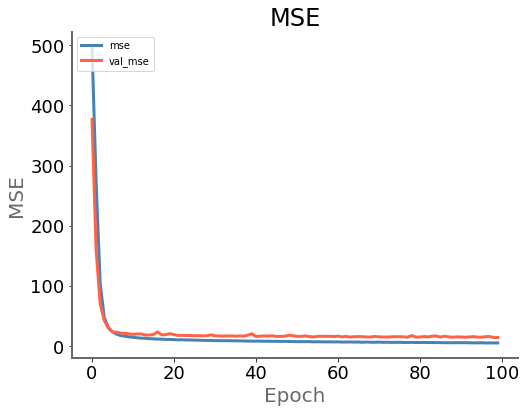

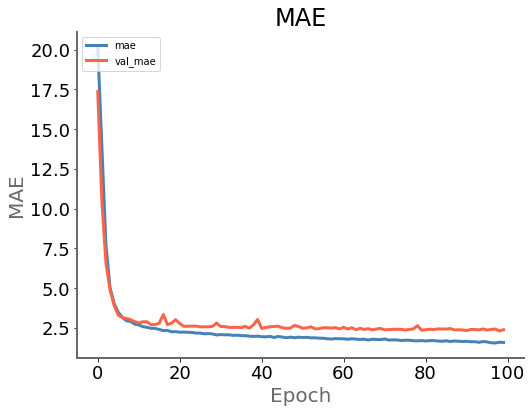

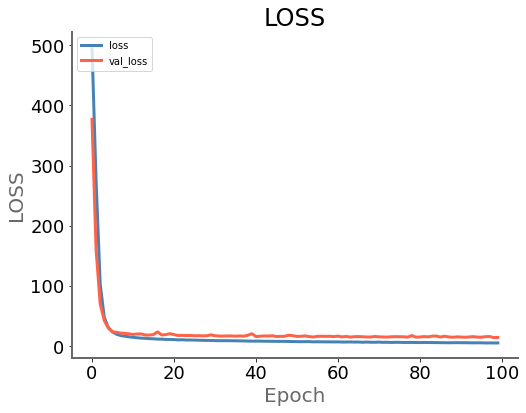

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 14.0080
x_test / mae       : 2.2920
x_test / mse       : 14.0080


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 8.81 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Wednesday 10 February 2021, 09:10:00
Duration is : 00:00:20 751ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>